In [1]:
import os,sys
import os,sys,inspect
from glob import glob
from os.path import exists, join
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import argparse

import torch
import torchvision, torchvision.transforms
import skimage.transform
import sklearn, sklearn.model_selection
import train_utils
import random
import torchxrayvision as xrv

d:\machineLearning\miniconda\envs\pytorch-gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import torchxrayvision as xrv
xrv.datasets

<module 'torchxrayvision.datasets' from 'd:\\machineLearning\\miniconda\\envs\\pytorch-gpu\\lib\\site-packages\\torchxrayvision\\datasets.py'>

In [2]:
datas = []
datas_names = []
transforms = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(512)])
data_aug = None
dataset = xrv.datasets.NIH_Dataset(
    imgpath="imgdata/images-224-NIH",
    transform=transforms, data_aug=data_aug, unique_patients=False, views=["PA","AP"])
datas.append(dataset)
datas_names.append("nih")
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, dataset)
print("datas_names", datas_names)
print("--------------------------")
print("data_distribution", datas)

Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.
datas_names ['nih']
--------------------------
data_distribution {'Atelectasis': {0.0: 100561, 1.0: 11559},
 'Cardiomegaly': {0.0: 109344, 1.0: 2776},
 'Consolidation': {0.0: 107453, 1.0: 4667},
 'Edema': {0.0: 109817, 1.0: 2303},
 'Effusion': {0.0: 98803, 1.0: 13317},
 'Emphysema': {0.0: 109604, 1.0: 2516},
 'Enlarged Cardiomediastinum': {},
 'Fibrosis': {0.0: 110434, 1.0: 1686},
 'Fracture': {},
 'Hernia': {0.0: 111893, 1.0: 227},
 'Infiltration': {0.0: 92226, 1.0: 19894},
 'Lung Lesion': {},
 'Lung Opacity': {},
 'Mass': {0.0: 106338, 1.0: 5782},
 'Nodule': {0.0: 105789, 1.0: 6331},
 'Pleural_Thickening': {0.0: 108735, 1.0: 3385},
 'Pneumonia': {0.0: 110689, 1.0: 1431},
 'Pneumothorax': {0.0: 106818, 1.0: 5302}}
[NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None]


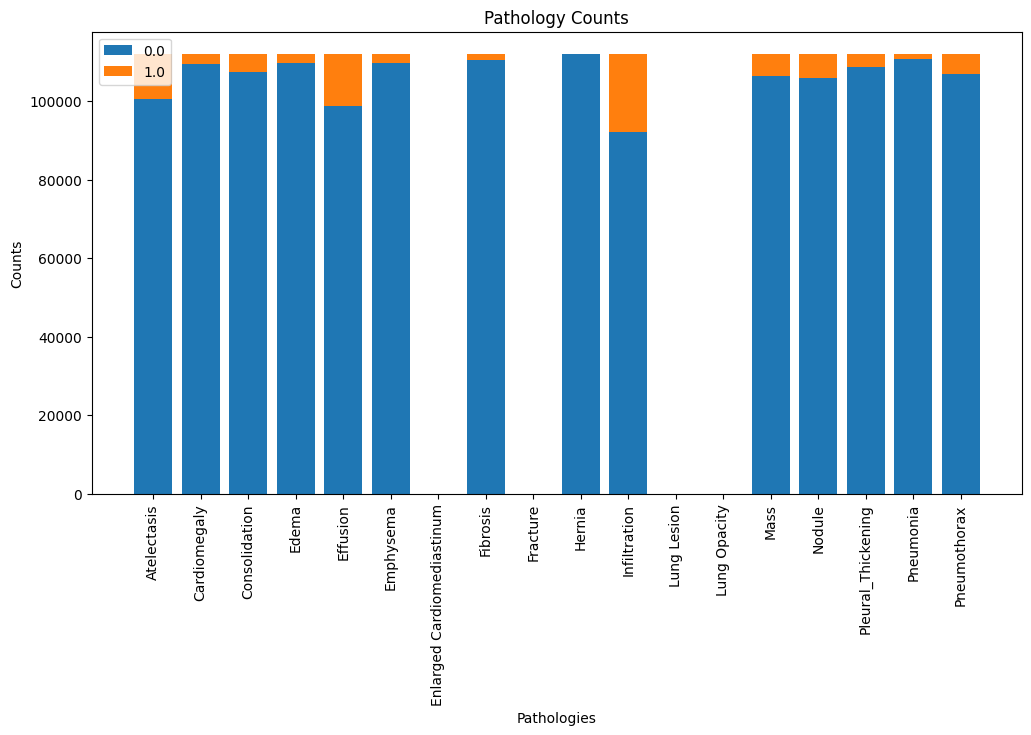

In [45]:
data = {'Atelectasis': {0.0: 100561, 1.0: 11559},
 'Cardiomegaly': {0.0: 109344, 1.0: 2776},
 'Consolidation': {0.0: 107453, 1.0: 4667},
 'Edema': {0.0: 109817, 1.0: 2303},
 'Effusion': {0.0: 98803, 1.0: 13317},
 'Emphysema': {0.0: 109604, 1.0: 2516},
 'Enlarged Cardiomediastinum': {},
 'Fibrosis': {0.0: 110434, 1.0: 1686},
 'Fracture': {},
 'Hernia': {0.0: 111893, 1.0: 227},
 'Infiltration': {0.0: 92226, 1.0: 19894},
 'Lung Lesion': {},
 'Lung Opacity': {},
 'Mass': {0.0: 106338, 1.0: 5782},
 'Nodule': {0.0: 105789, 1.0: 6331},
 'Pleural_Thickening': {0.0: 108735, 1.0: 3385},
 'Pneumonia': {0.0: 110689, 1.0: 1431},
 'Pneumothorax': {0.0: 106818, 1.0: 5302}}
# 提取数据
labels = list(data.keys())
values_0 = [v.get(0.0, 0) for v in data.values()]  # 处理空字典
values_1 = [v.get(1.0, 0) for v in data.values()]  # 处理空字典

# 绘制条形图
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(labels, values_0, label='0.0')
ax.bar(labels, values_1, bottom=values_0, label='1.0')
ax.set_xticklabels(labels, rotation=90)
# 添加标签和标题
plt.xlabel("Pathologies")
plt.ylabel("Counts")
plt.title("Pathology Counts")

# 添加图例
ax.legend()

# 显示图表
plt.show()
fig.savefig('figure/data_nih.png', bbox_inches = 'tight')


In [46]:
#cut out training sets
train_datas = []
test_datas = []
for i, dataset in enumerate(datas):
        
    # give patientid if not exist
    if "patientid" not in dataset.csv:
        dataset.csv["patientid"] = ["{}-{}".format(dataset.__class__.__name__, i) for i in range(len(dataset))]
            
    gss = sklearn.model_selection.GroupShuffleSplit(train_size=0.8,test_size=0.2, random_state=0)
        
    train_inds, test_inds = next(gss.split(X=range(len(dataset)), groups=dataset.csv.patientid))
    train_dataset = xrv.datasets.SubsetDataset(dataset, train_inds)
    test_dataset = xrv.datasets.SubsetDataset(dataset, test_inds)
        
    train_datas.append(train_dataset)
    test_datas.append(test_dataset)

In [47]:
print("train_datas", train_datas)
print("test_datas", test_datas)

train_datas {'Atelectasis': {0.0: 80501, 1.0: 9363},
 'Cardiomegaly': {0.0: 87618, 1.0: 2246},
 'Consolidation': {0.0: 86091, 1.0: 3773},
 'Edema': {0.0: 87983, 1.0: 1881},
 'Effusion': {0.0: 79131, 1.0: 10733},
 'Emphysema': {0.0: 87858, 1.0: 2006},
 'Enlarged Cardiomediastinum': {},
 'Fibrosis': {0.0: 88515, 1.0: 1349},
 'Fracture': {},
 'Hernia': {0.0: 89675, 1.0: 189},
 'Infiltration': {0.0: 73894, 1.0: 15970},
 'Lung Lesion': {},
 'Lung Opacity': {},
 'Mass': {0.0: 85292, 1.0: 4572},
 'Nodule': {0.0: 84769, 1.0: 5095},
 'Pleural_Thickening': {0.0: 87200, 1.0: 2664},
 'Pneumonia': {0.0: 88705, 1.0: 1159},
 'Pneumothorax': {0.0: 85637, 1.0: 4227}}
[SubsetDataset num_samples=89864
└ of NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None]
test_datas {'Atelectasis': {0.0: 20060, 1.0: 2196},
 'Cardiomegaly': {0.0: 21726, 1.0: 530},
 'Consolidation': {0.0: 21362, 1.0: 894},
 'Edema': {0.0: 21834, 1.0: 422},
 'Effusion': {0.0: 19672, 1.0: 2584},
 'Emphysema': {0.0: 21746, 1.0:

In [48]:
if len(datas) == 0:
    raise Exception("no dataset")
elif len(datas) == 1:
    train_dataset = train_datas[0]
    test_dataset = test_datas[0]
else:
    print("merge datasets")
    train_dataset = xrv.datasets.Merge_Dataset(train_datas)
    test_dataset = xrv.datasets.Merge_Dataset(test_datas)

In [49]:
print("train_dataset.labels.shape", train_dataset.labels.shape)
print("test_dataset.labels.shape", test_dataset.labels.shape)
print("train_dataset",train_dataset)
print("test_dataset",test_dataset)

train_dataset.labels.shape (89864, 18)
test_dataset.labels.shape (22256, 18)
train_dataset {'Atelectasis': {0.0: 80501, 1.0: 9363},
 'Cardiomegaly': {0.0: 87618, 1.0: 2246},
 'Consolidation': {0.0: 86091, 1.0: 3773},
 'Edema': {0.0: 87983, 1.0: 1881},
 'Effusion': {0.0: 79131, 1.0: 10733},
 'Emphysema': {0.0: 87858, 1.0: 2006},
 'Enlarged Cardiomediastinum': {},
 'Fibrosis': {0.0: 88515, 1.0: 1349},
 'Fracture': {},
 'Hernia': {0.0: 89675, 1.0: 189},
 'Infiltration': {0.0: 73894, 1.0: 15970},
 'Lung Lesion': {},
 'Lung Opacity': {},
 'Mass': {0.0: 85292, 1.0: 4572},
 'Nodule': {0.0: 84769, 1.0: 5095},
 'Pleural_Thickening': {0.0: 87200, 1.0: 2664},
 'Pneumonia': {0.0: 88705, 1.0: 1159},
 'Pneumothorax': {0.0: 85637, 1.0: 4227}}
SubsetDataset num_samples=89864
└ of NIH_Dataset num_samples=112120 views=['PA', 'AP'] data_aug=None
test_dataset {'Atelectasis': {0.0: 20060, 1.0: 2196},
 'Cardiomegaly': {0.0: 21726, 1.0: 530},
 'Consolidation': {0.0: 21362, 1.0: 894},
 'Edema': {0.0: 21834, 1

In [68]:
model_path = "train_output/nih-resnet50-test-best.pt"
model = torch.load(model_path)

In [69]:
# Dataloader
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=8,
                                            shuffle=None,
                                            num_workers=0, pin_memory=False)
results = train_utils.valid_test_epoch("test", 0, model, "cuda", test_loader, torch.nn.BCEWithLogitsLoss(), limit=99999999)

Epoch 1 - test - Loss = 2.1966: 100%|██████████| 2782/2782 [12:04<00:00,  3.84it/s]


Epoch 1 - test - Avg AUC = 0.8009


In [71]:
perf_dict = {}
all_threshs = []
all_min = []
all_max = []
all_ppv80 = []
file = open('resultat/nih-resnet50-test-best','a')
for i, patho in enumerate(test_dataset.pathologies):
    opt_thres = np.nan
    opt_min = np.nan
    opt_max = np.nan
    ppv80_thres = np.nan
    if (len(results[3][i]) > 0) and (len(np.unique(results[3][i])) == 2):
        
        #sigmoid
        all_outputs = 1.0/(1.0 + np.exp(-results[2][i]))
        
        fpr, tpr, thres = sklearn.metrics.roc_curve(results[3][i], all_outputs)
        pente = tpr - fpr
        opt_thres = thres[np.argmax(pente)]
        opt_min = all_outputs.min()
        opt_max = all_outputs.max()
        
        ppv, recall, thres = sklearn.metrics.precision_recall_curve(results[3][i], all_outputs)
        ppv80_thres_idx = np.where(ppv > 0.8)[0][0]
        ppv80_thres = thres[ppv80_thres_idx-1]
        
        auc = sklearn.metrics.roc_auc_score(results[3][i], all_outputs)
        
        print(patho, auc)
        file.write(str(patho) + ' ' + str(auc) + '\n')
        perf_dict[patho] = str(round(auc,2))
        
    else:
        perf_dict[patho] = "-"
        
    all_threshs.append(opt_thres)
    all_min.append(opt_min)
    all_max.append(opt_max)
    all_ppv80.append(ppv80_thres)


file.write("pathologies" + str(test_dataset.pathologies) +'\n')
file.write("op_threshs" + str(all_threshs)+'\n')
file.write("min" + str(all_min)+'\n')
file.write("max" + str(all_max)+'\n')
file.write("ppv80" + str(all_ppv80)+'\n')
file.close()

print("-----------------------------------------------------------")    
print("pathologies",test_dataset.pathologies)
    
print("op_threshs",str(all_threshs).replace("nan","np.nan"))
    
print("min",str(all_min).replace("nan","np.nan"))
    
print("max",str(all_max).replace("nan","np.nan"))

print("ppv80",str(all_ppv80).replace("nan","np.nan"))

Atelectasis 0.7695471758676612
Consolidation 0.7786001748489394
Infiltration 0.6868422374004182
Pneumothorax 0.8201871137252232
Edema 0.8856974230807466
Emphysema 0.872652486912175
Fibrosis 0.7653056444803588
Effusion 0.8627664656244768
Pneumonia 0.726670867582841
Pleural_Thickening 0.7506275466155634
Cardiomegaly 0.9057027576731818
Nodule 0.7043414308764345
Mass 0.8125226285122789
Hernia 0.8709640357983806
-----------------------------------------------------------
pathologies ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Lung Lesion', 'Fracture', 'Lung Opacity', 'Enlarged Cardiomediastinum']
op_threshs [0.061641656, 0.03588539, 0.19524075, 0.030528711, 0.020668479, 0.007156254, 0.023056982, 0.0901551, 0.015201185, 0.019687265, 0.012241903, 0.042621396, 0.043535836, 0.001578105, np.nan, np.nan, np.nan, np.nan]
min [0.00085373764, 0.0004882011